<h3>Challenge 1</h3>
<h1>House Pricing Prediction</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<h3>Damiano Franzo, Alessandro Nori, Dario Salza</h3>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import norm
from scipy import stats
from math import log, sqrt, exp

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet, ElasticNetCV, BayesianRidge
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest, AdaBoostRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

from functools import reduce

from time import time

from xgboost import XGBRegressor

base = "./kaggle_data/"

<h2>Utility Functions</h2>

In [2]:
def sanitize_na(df, median = None, mode = None):
    
    df_na = df.isnull().sum()
    print("Features with missing values before: ", df_na.drop(df_na[df_na == 0].index))
    
    # Using data description, fill these missing values with "None"
    for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
               "GarageType", "GarageFinish", "GarageQual", "GarageCond",
               "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
                "BsmtFinType2", "MSSubClass", "MasVnrType"):
        df[col].fillna('None',  inplace=True)

    if median is None:
        # The area of the lot out front is likely to be similar to the houses in the local neighbourhood
        # Therefore, let's use the median value of the houses in the neighbourhood to fill this feature (median because it is resistant to outliers)
        median = df.groupby("Neighborhood")["LotFrontage"].median()
        
    for k, v in median.items():
         df.loc[df["Neighborhood"] == k,"LotFrontage"] = df[df["Neighborhood"] == k]["LotFrontage"].fillna(v)    
    

    # Using data description, fill these missing values with 0 
    for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", 
               "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
               "BsmtFullBath", "BsmtHalfBath"):
        df[col].fillna(0, inplace=True)
        
    # Fill these features with their mode, the most commonly occuring value. This is okay since there are a low number of missing values for these features
    modecols = ['MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType','Functional']
    if mode is None:
        mode = {}
        for col in modecols:
            mode[col] = df[col].mode()[0]
    for col in modecols:
        df[col].fillna(mode[col], inplace=True)
        

    df_na = df.isnull().sum()
    print("Features with missing values after: ", df_na.drop(df_na[df_na == 0].index))
    return median, mode

def map_ordinal_features(df):
    # External quality and condition
    exter_qual_todict = {'Fa':1, 'TA':2, 'Gd':3, 'Ex':4, 'None':0}
    df['ExterQual']=df.ExterQual.apply(exter_qual_todict.get)

    exter_cond_todict =  {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, 'None':0}
    df['ExterCond']=df.ExterCond.apply(exter_cond_todict.get)

    # Land slope
    land_slope_todict = {'Gtl':1, 'Mod':2, 'Sev':3}
    df['LandSlope']=df.LandSlope.apply(land_slope_todict.get)

    # Basement
    bsmt_qual_todict = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, 'None':0}
    df['BsmtQual']=df.BsmtQual.apply(bsmt_qual_todict.get)

    bsmt_cond_todict = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, 'None':0}
    df['BsmtCond'] = df.BsmtCond.apply(bsmt_cond_todict.get)

    bsmt_exposure_todict = {'No':1, 'Mn':2, 'Av':3, 'Gd':4, 'None':0}
    df['BsmtExposure'] = df.BsmtExposure.apply(bsmt_exposure_todict.get)

    bsmt_fin_type_todict = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
    df['BsmtFinType1'] = df.BsmtFinType1.apply(bsmt_fin_type_todict.get)
    df['BsmtFinType2'] = df['BsmtFinType2'].apply(bsmt_fin_type_todict.get)

    # Heating
    heating_qc_todict = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
    df['HeatingQC'] = df['HeatingQC'].apply(heating_qc_todict.get)

    # Kitchen
    kitchen_qual_todict = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
    df['KitchenQual'] = df['KitchenQual'].apply(kitchen_qual_todict.get)

    # Fireplace
    fireplace_qu_todict = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, 'None':0}
    df['FireplaceQu'] = df['FireplaceQu'].apply(fireplace_qu_todict.get)

    # Garage
    garage_finish_todict = {'None':0, 'Unf':1, 'RFn':2, 'Fin':3}
    df['GarageFinish'] = df['GarageFinish'].apply(garage_finish_todict.get)

    garage_qual_todict = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, 'None':0}
    df['GarageQual'] = df['GarageQual'].apply(garage_qual_todict.get)

    garage_cond_todict = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, 'None':0}
    df['GarageCond'] = df['GarageCond'].apply(garage_cond_todict.get)

    # Paved Driveway
    paved_drive_todict = {'N':0, 'P':1, 'Y':2}
    df['PavedDrive'] = df['PavedDrive'].apply(paved_drive_todict.get)
    
    

# Reading Dataset

In [3]:
# Read the .csv file 
rawTrainDF = pd.read_csv(base + 'train.csv')
test_df = pd.read_csv(base + 'test.csv')

In [4]:
print('Train dataset size: ', rawTrainDF.Id.size)
print('Test dataset size: ', test_df.Id.size)

Train dataset size:  1460
Test dataset size:  1459


## NaN attributes
Since in the dataset many attributes have as a possible value NA, which may break the regression algorithms, we map these values in 3 different ways, depending on the feature type:<br>
<ul>
    <li> <b>Nullable Categorical Attributes:</b> For these attributes, according to the data description, NA is a plausible value (ad example, if they refer to an optional feature of the house). In this case, we replace NA with 'None'</li>
    <li> <b>Numerical Attributes: </b> For numerical attributes representing characteristics of non-present optional features, we replace NA values with zero, while for LotFrontage, that cannot be plausibly zero, we use the median of the observed values for its neighborhood in the training dataset</li>
    <li> <b>Non-nullable Categorical Attributes: </b> These are the attributes that, per description, cannot be null. In this case, we repair NA values with the mode of the observed values in the training dataset. </li>
   </ul>

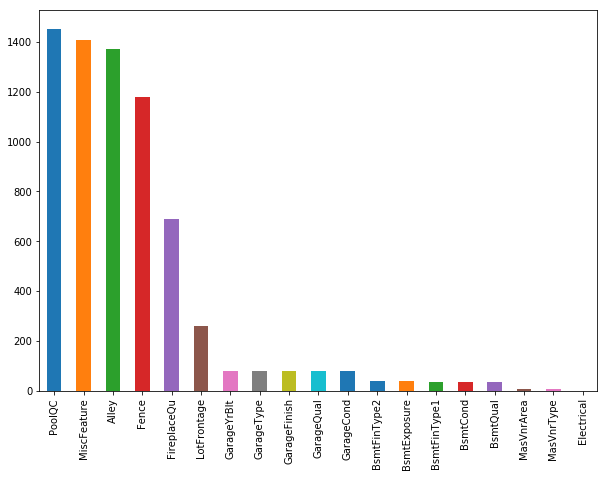

In [5]:
# aggregate all null values 
rawTrainDF_na = rawTrainDF.isnull().sum()

# get rid of all the values with 0 missing values and plot 
rawTrainDF_na = rawTrainDF_na.drop(rawTrainDF_na[rawTrainDF_na == 0].index).sort_values(ascending=False)
plt.subplots(figsize =(10, 7))
rawTrainDF_na.plot(kind='bar');

In [6]:
print('Cleaning training data...')
median, mode = sanitize_na(rawTrainDF);

Cleaning training data...
Features with missing values before:  LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
Features with missing values after:  Series([], dtype: int64)


## Outliers
Outliers in respect to pricing may pollute the regression results, shifting the predictions outside the correct range. As we have few houses which prices are over 400.000, we drop such houses, that fall outside the tail of the gaussian distribution. We decide to drop at 400.000 and not exactly at the crossing because it is possible to notice that such mild outliers may still be explained by some special features they present.


 mu = 180921.20 and sigma = 79415.29



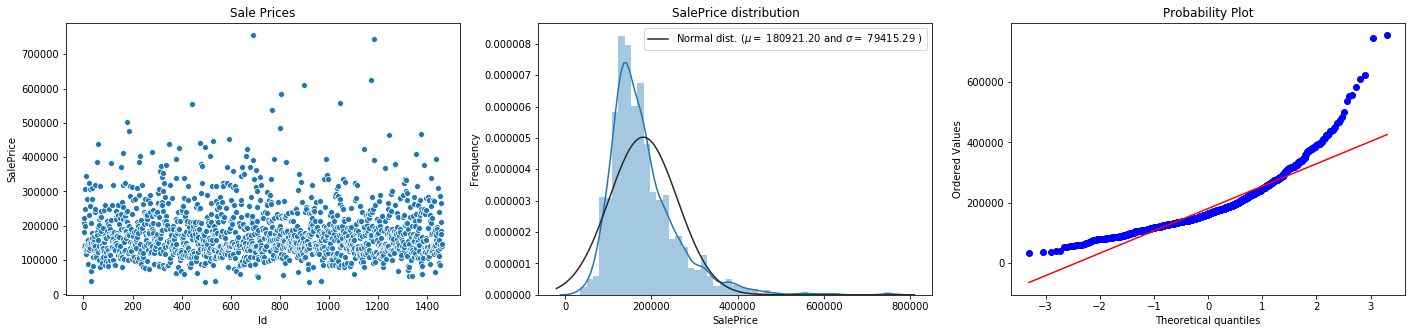

Skewness: 1.882876
Kurtosis: 6.536282


In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(24,5))

sns.scatterplot(rawTrainDF.Id, rawTrainDF.SalePrice, palette='ocean', ax=ax[0])
ax[0].set_title('Sale Prices')

sns.distplot(rawTrainDF['SalePrice'] , fit=norm, ax=ax[1]);

(mu, sigma) = norm.fit(rawTrainDF['SalePrice']) # parameters for an ideal gaussian distribution with our data
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
ax[1].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax[1].set_ylabel('Frequency')
ax[1].set_title('SalePrice distribution')

res = stats.probplot(rawTrainDF['SalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % rawTrainDF['SalePrice'].skew())
print("Kurtosis: %f" % rawTrainDF['SalePrice'].kurt())

<p>The high value on Kurtosis (greather than 3) indicates that the distribution asymptotically approach zero much slower than a Gaussian and therefore produces more outliers than the normal distribution.<p>
<p>The normal distribution is what we would like to achieve removing outliers.</p>

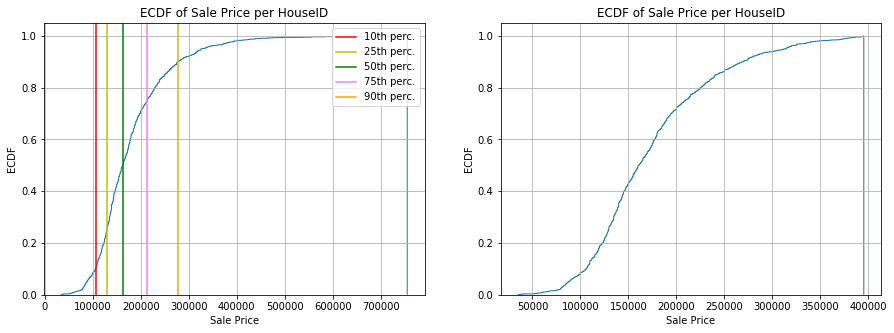

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

rawTrainDF['SalePrice'].hist(ax=ax[0], cumulative=True, density=True, bins=1000, histtype='step')

colors = ['r', 'y', 'g', 'violet', 'orange']
# Calculate and plot the 5 important percentiles
for i, quantile in enumerate([.1, 0.25, .5, .75, .9]):
    ax[0].axvline(rawTrainDF['SalePrice'].quantile(quantile), label='%.0fth perc.' % (quantile*100), color=colors[i])

ax[0].set_title('ECDF of Sale Price per HouseID')
ax[0].set_xlabel('Sale Price')
ax[0].set_ylabel('ECDF')
ax[0].legend(loc='best')

cleanedTrainDF = rawTrainDF[rawTrainDF['SalePrice'] <= 400000]

cleanedTrainDF['SalePrice'].hist(ax=ax[1], cumulative=True, density=True, bins=1000, histtype='step')
ax[1].set_title('ECDF of Sale Price per HouseID')
ax[1].set_xlabel('Sale Price')
ax[1].set_ylabel('ECDF')

plt.show()

## Dimensionality reduction
We notice that the attribute 'Utilities' contains only two distinct values, of which one appears only once in the entire training set: this value can only result in overfitting, as there not enough information to generalize. For this reason we drop this column.

Distinct values for column 'Utilities':  ['AllPub' 'NoSeWa']
Number of times 'NoSeWa' appears in the dataset: 1


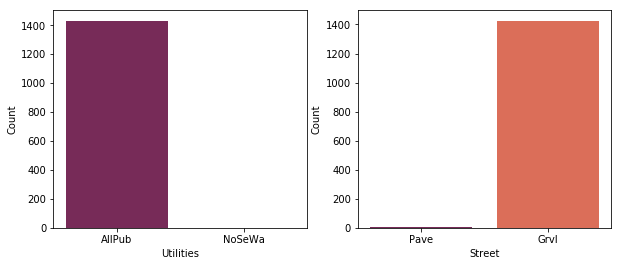

In [9]:
fig, ax = plt.subplots(ncols = 2, figsize=(10,4))

sns.barplot(x=cleanedTrainDF.Utilities.unique(), y=cleanedTrainDF.groupby(by='Utilities', as_index=False).count()['Id'], palette="rocket", ax=ax[0])
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Utilities')

sns.barplot(x=cleanedTrainDF.Street.unique(), y=cleanedTrainDF.groupby(by='Street', as_index=False).count()['Id'], palette="rocket", ax=ax[1])
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Street')

print("Distinct values for column 'Utilities': ", cleanedTrainDF.Utilities.unique())
print("Number of times 'NoSeWa' appears in the dataset:", cleanedTrainDF.Utilities[cleanedTrainDF.Utilities == 'NoSeWa'].size)

The same reasoning can be applied to other features, such as PoolArea, PoolQC, Street, Functional, RoofMatl.

In [10]:
columns_todrop = ['Utilities', 'PoolArea', 'PoolQC', 'Street', 'Functional', 'RoofMatl']
cleanedTrainDF = cleanedTrainDF.drop(columns_todrop, axis=1)

<div>
    <h2>Ordinal Features</h2>
    <p>Some features have naturally ordered categories or the sale price tends to increase with a particular order, so it's convenient to map their string values with numerical values.</p>
</div>

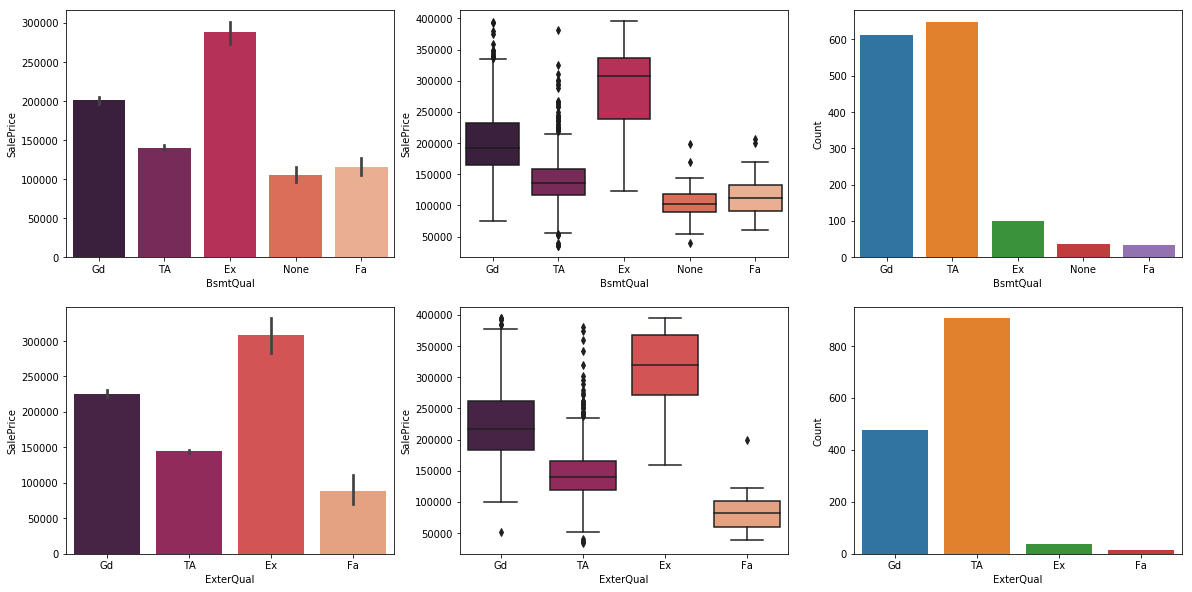

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
sns.barplot(x='BsmtQual', y='SalePrice', data=cleanedTrainDF, palette="rocket", ax=ax[0][0])
sns.boxplot(x='BsmtQual', y='SalePrice', data=cleanedTrainDF, palette='rocket', ax=ax[0][1])
sns.countplot(x='BsmtQual', data=cleanedTrainDF, ax=ax[0][2])
ax[0][2].set_ylabel('Count')
ax[0][2].set_xlabel('BsmtQual')


sns.barplot(x='ExterQual', y='SalePrice', data=cleanedTrainDF, palette="rocket", ax=ax[1][0])
sns.boxplot(x='ExterQual', y='SalePrice', data=cleanedTrainDF, palette='rocket', ax=ax[1][1])
sns.countplot(x='ExterQual', data=cleanedTrainDF, ax=ax[1][2])
ax[1][2].set_ylabel('Count')
ax[1][2].set_xlabel('ExterQual')

plt.show()

In [12]:
map_ordinal_features(cleanedTrainDF)

### Foundation

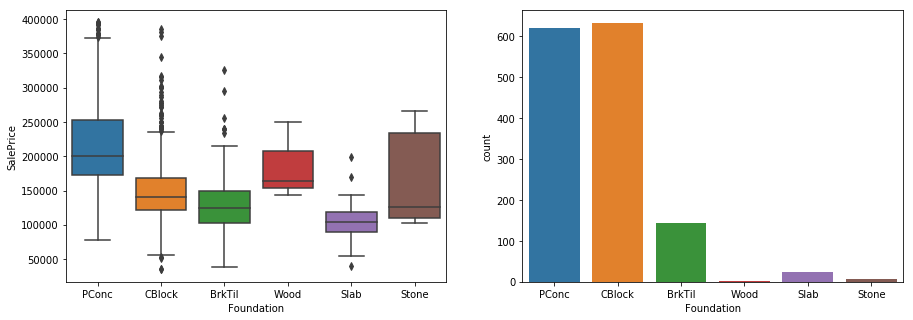

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(x='Foundation', y='SalePrice', data=cleanedTrainDF, ax=ax[0])
sns.countplot(x='Foundation', data=cleanedTrainDF, ax=ax[1])
plt.show()

We can then notice, that, while the 'Foundation' feature doesn't have an inherent order, its 3 categories seems to present a strong positive correlation with Sale Price. For this reason, we treat it as ordinal.

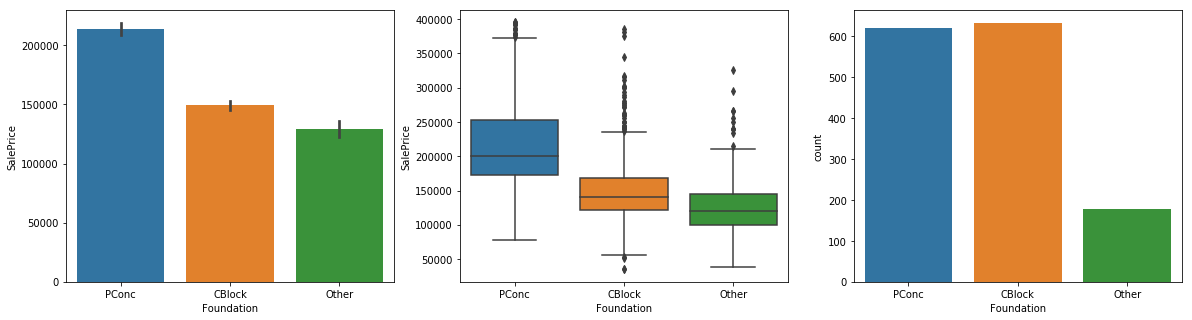

In [14]:
# if Foundation doesn't belong to PConc or CBlock, convert it to 'Other'
cleanedTrainDF.loc[cleanedTrainDF['Foundation'].isin(['BrkTil', 'Wood', 'Slab', 'Stone']),'Foundation'] = 'Other'

fig, ax = plt.subplots(ncols=3, figsize=(20,5))
sns.barplot(x='Foundation', y='SalePrice', data=cleanedTrainDF, ax=ax[0])
sns.boxplot(x='Foundation', y='SalePrice', data=cleanedTrainDF, ax=ax[1])
sns.countplot(x='Foundation', data=cleanedTrainDF, ax=ax[2])
plt.show()

In [15]:
foundation_todict = {'PConc':3, 'CBlock':2, 'Other':1}
cleanedTrainDF['Foundation'] = cleanedTrainDF['Foundation'].apply(foundation_todict.get)

<h3>Fence</h3>

<p>The feature 'Fence' representing the fence quality is an ordinal attribute but in this case we can't see strong correlation between it and 'SalePrice'. Moreover most of the houses don't have a fence.</p>

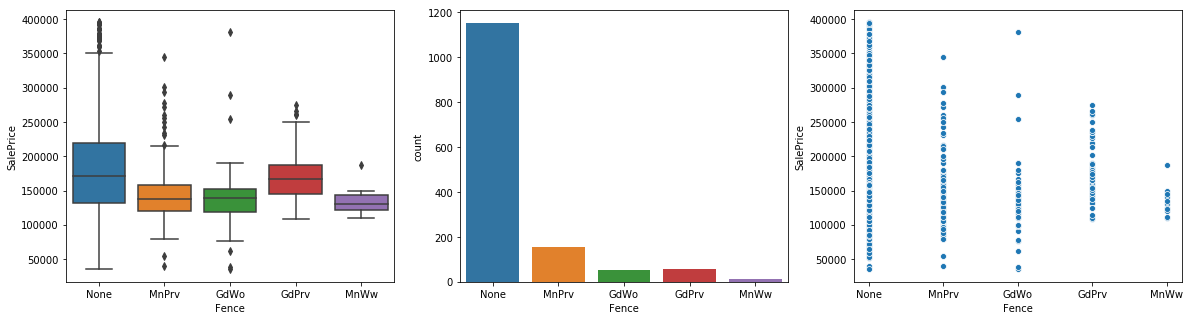

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
sns.boxplot(x='Fence', y='SalePrice', data=cleanedTrainDF, ax=ax[0])
sns.countplot(x='Fence', data=cleanedTrainDF, ax=ax[1])
sns.scatterplot(x='Fence', y='SalePrice', data=cleanedTrainDF, ax=ax[2])
plt.show()

In [17]:
cleanedTrainDF = cleanedTrainDF.drop('Fence', axis=1)

# Feature Engineering

For years, normalization becomes important, as in their untreated form the relative change is very low. We want instead to make this change more relevant, so it can be more easily captured by the regression algorithms.

We notice a strong positive correlation between the remodernization year and sale price. To normalize the value, we compute the difference between the current year and the remodernization (that is, how many years have passed from the modernization). To enforce however a positive correlation (and not an anticorrelation), we take the contrary of this value, adding at it 100.

In [18]:
def diff_remod_built(df):
    df['RemodDiffYear'] = 100 - (2010 - df['YearRemodAdd'])
    df = df.drop('YearRemodAdd', axis=1)
    return df

In [19]:
cleanedTrainDF = diff_remod_built(cleanedTrainDF)

YearBuilt has also a strong correlation with sale price. To normalize it, we divide the values in equi-depth bins, treating them as an ordinal feature (which it inherently is). Regarding GarageYrBlt, instead, we also notice a slightly weaker correlation, but still one that is significant. To normalize, we again divide it into equi-depth bins, however, we cannot treat it as a ordinal value, because we could not represent cleanly the lack of garage. Thus, we treat the different bins as a categorical attribute.

In [20]:
# bins has to be a sequence of scalars
def year_binner(df, binsYearBuilt, binsGarageBuilt):
    df['YearBuilt'] = pd.cut(df['YearBuilt'], binsYearBuilt, labels=False)
    lab = []
    pre = None
    for binz in binsGarageBuilt:
        if pre is None:
            pre = str(binz)
            continue
        lab.append(pre+"-"+str(binz))
        pre=str(binz)
    df['GarageYrBlt'] = pd.cut(df['GarageYrBlt'], binsGarageBuilt, labels=lab)

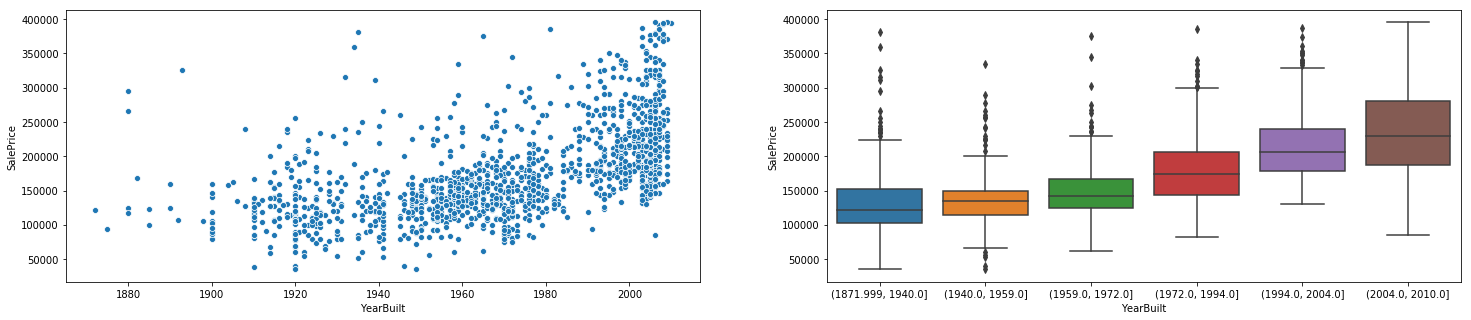

YearBuilt bins:  [(1994.0, 2004.0], (1972.0, 1994.0], (1871.999, 1940.0], (1959.0, 1972.0], (2004.0, 2010.0], (1940.0, 1959.0]]
Categories (6, interval[float64]): [(1871.999, 1940.0] < (1940.0, 1959.0] < (1959.0, 1972.0] < (1972.0, 1994.0] < (1994.0, 2004.0] < (2004.0, 2010.0]]


In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(25, 5))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=cleanedTrainDF, ax=ax[0])

# get equi-depth bins from YearBuilt
year_built_bins = pd.qcut(cleanedTrainDF['YearBuilt'], 6)
sns.boxplot(x=year_built_bins, y=cleanedTrainDF['SalePrice'], ax=ax[1])
plt.show()

print('YearBuilt bins: ', year_built_bins.unique())

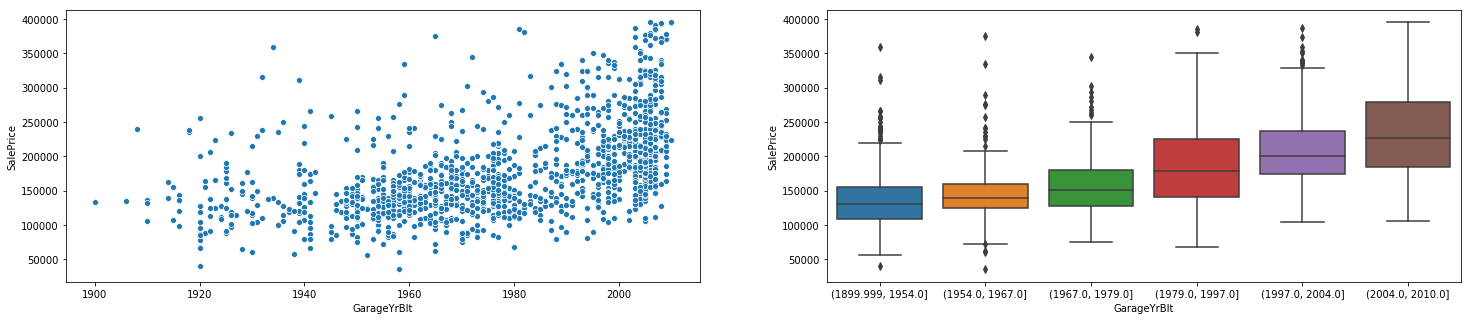

GarageYrBlt bins:  [(1997.0, 2004.0], (1967.0, 1979.0], (1979.0, 1997.0], (1899.999, 1954.0], (1954.0, 1967.0], (2004.0, 2010.0]]
Categories (6, interval[float64]): [(1899.999, 1954.0] < (1954.0, 1967.0] < (1967.0, 1979.0] < (1979.0, 1997.0] < (1997.0, 2004.0] < (2004.0, 2010.0]]


In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(25, 5))
sns.scatterplot(x='GarageYrBlt', y='SalePrice', data=cleanedTrainDF[cleanedTrainDF['GarageYrBlt']>0], ax=ax[0])
gryear_built_bins = pd.qcut(cleanedTrainDF.loc[cleanedTrainDF['GarageYrBlt']>1,'GarageYrBlt'], 6)
sns.boxplot(x=gryear_built_bins, y=cleanedTrainDF.loc[cleanedTrainDF['GarageYrBlt']>0,'SalePrice'], ax=ax[1])
plt.show()

print('GarageYrBlt bins: ', gryear_built_bins.unique())

In [23]:
# transform YearBuilt in an ordinal feature based on bucket representing range of years
yrbins = [1,1940,1959,1972,1994,2004,2010]
gybins = [-1, 1, 1954, 1967, 1980, 1997, 2004, 2010]
year_binner(cleanedTrainDF, yrbins, gybins)

Regarding YrSold, we normalize it taking the difference between the actual year of sale and the minimum in the dataset, that is 2006.

In [24]:
def yrsold_scaleback(df, year_zero):
    df["YrSold"] = df["YrSold"] - year_zero

In [25]:
yrsold_scaleback(cleanedTrainDF, 2006)

## Training preparation

For the test data, we then repeat all the steps performed on the train data.

In [26]:
def test_cleaning_pipeline(df, columns_todrop, median, mode, yrbins, gybins, foundation_todict):
    sanitize_na(df, median, mode);
    df = df.drop(columns_todrop, axis=1)
    map_ordinal_features(df)
    df = df.drop('Fence', axis=1)
    df = diff_remod_built(df)
    year_binner(df, yrbins, gybins)
    yrsold_scaleback(df, 2006)
    df.drop("Id", axis = 1, inplace = True)
    df.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)
    test_df.loc[test_df['Foundation'].isin(['BrkTil', 'Wood', 'Slab', 'Stone']),'Foundation'] = 'Other'
    test_df['Foundation'] = test_df['Foundation'].apply(foundation_todict.get)
    return df

In [27]:
#Save the 'Id' column
train_ID = cleanedTrainDF['Id']
train_price = cleanedTrainDF['SalePrice']
test_ID = test_df['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train_df = cleanedTrainDF.drop("Id", axis = 1)
train_df.drop('SalePrice', axis=1, inplace=True)
train_df.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)

In [28]:
test_df = test_cleaning_pipeline(test_df, columns_todrop, median, mode, yrbins, gybins, foundation_todict)

Features with missing values before:  MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64
Features with missing values after:  Utilities    2
dtype: int64


In [29]:
assert(test_df.keys().size == train_df.keys().size)

We then create dummy variables for every categorical value, aligning them between train and test data.

In [30]:
train_dummies = pd.get_dummies(train_df)
test_dummies = pd.get_dummies(test_df)

In [31]:
train_dummies, test_dummies = train_dummies.align(test_dummies, join='outer', axis=1, fill_value=0)

In [32]:
print(train_dummies.keys().size)
print(test_dummies.keys().size)
assert(test_dummies.keys().size == train_dummies.keys().size)
train_dummies['SalePrice'] = train_price

220
220


### Data correlation

#### Raw Data Correlation

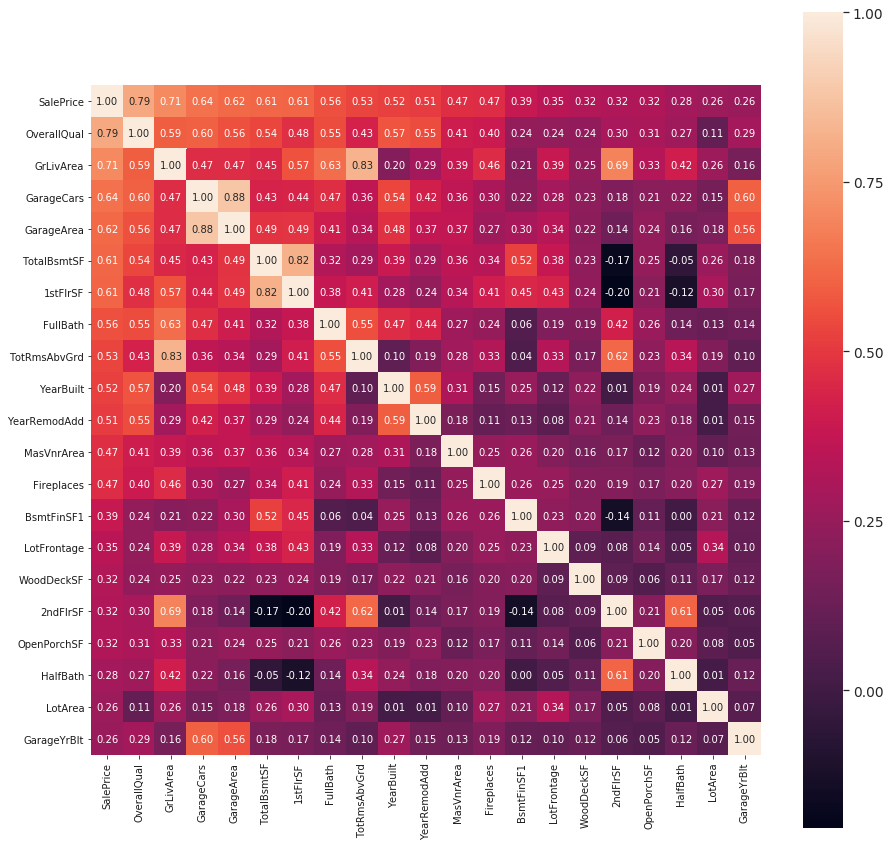

In [33]:
#correlation matrix
corrmat = rawTrainDF.corr()
f, ax = plt.subplots(figsize=(15, 15))
k = 21 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(rawTrainDF[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Processed data correlation

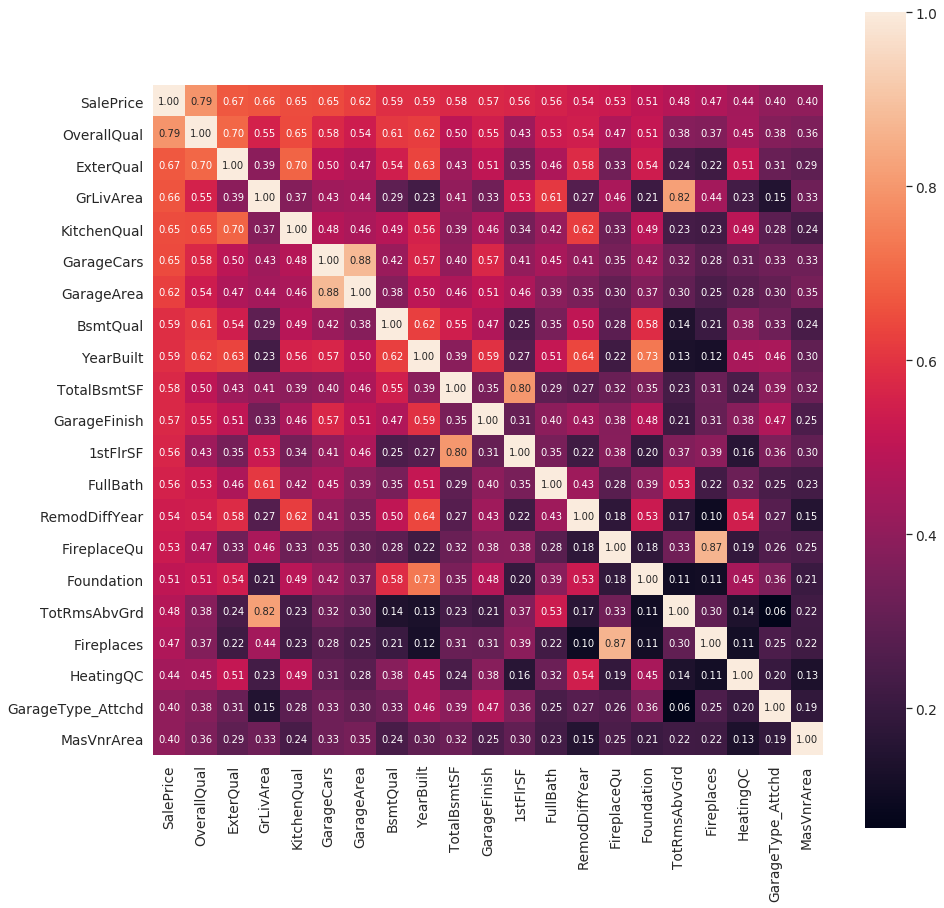

Anti Correlations
GarageType_Detchd       -0.384079
MasVnrType_None         -0.374774
MSZoning_RM             -0.321696
CentralAir_N            -0.281566
GarageType_None         -0.265876
GarageYrBlt_-1-1        -0.265876
LotShape_Reg            -0.265071
GarageYrBlt_1-1954      -0.235546
Neighborhood_OldTown    -0.219878
Electrical_FuseA        -0.211870
GarageYrBlt_1954-1967   -0.196589
Neighborhood_Edwards    -0.193977
SaleType_WD             -0.192633
Neighborhood_NAmes      -0.190172
Neighborhood_IDOTRR     -0.184731
Name: SalePrice, dtype: float64


In [34]:
corrmat = train_dummies.corr()
f, ax = plt.subplots(figsize=(15, 15))
k = 21 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_dummies[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

print("Anti Correlations")
k = 15 #number of variables for heatmap
cols = corrmat.nsmallest(k, 'SalePrice')['SalePrice']
print(cols)

Comparing the correlation matrix before and after the feature engineering, we notice that, while the correlation on some values has lowered slightly (this due the removal of the outliers), generally we notice an increase of correlation on some already present values (like YearBuilt, or RemodDiffYear over YearRemodAdd), and the introduction of new, highly correlated attributes (like ExterQuality, or Foundation). 

# Modelization

The dataset is split between the training dataset and validation dataset.

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(train_dummies[train_dummies.keys()[:-1]],  train_dummies['SalePrice'], test_size=0.2)
# Log Trasformation
y_train, y_valid = [log(y) for y in y_train],  [log(y) for y in y_valid]

In [36]:
X = [X_train, X_valid]
Y = [y_train, y_valid]
for x in X:
    print("Shape of dataframe x: ", x.shape)

Shape of dataframe x:  (1145, 220)
Shape of dataframe x:  (287, 220)


In [37]:
# Return the cardinality of the grid
def get_cardinality_of_exploration(d):
    return reduce(lambda a, b: a * b, [len(i) for i in d.values()])


# This function returns the value of the metrix utilized to calculate the error
def log_err(target, prediction):
    return sqrt(mean_squared_error(target, prediction))


# This function allows to optimize the accuracy of the model across different parameters configurations generated by the grid
def OptimiseParameters(model, X, y, parameters_grid, n_jobs=1, scoring='r2', instantiated=False):
    # with this option is possible to pass an unistantiated model to the function
    if not instantiated:
        modelCV = model()
    # The GridSearchCV class allows to explore all the parameters configurations generated by the grid
    cross_validation_model = GridSearchCV(estimator=modelCV, param_grid=parameters_grid, cv=10, n_jobs=n_jobs, scoring=scoring)
    cross_validation_model.fit(X,y)
    print("Best parameters configuration: {}\n".format(cross_validation_model.best_params_))
    print("Best R2 score: {}\n".format(cross_validation_model.best_score_))
    # best model is returned
    return cross_validation_model


# This functions is just an utility to display the error of all the models within a dictionary.
def show_errors(d, X, y_true):
    print("ERRORS: \n")
    for k, v in d.items():
        print("Regressor: {0}".format(k))
        y_pred = v.predict(X)
        print("Error on testing dataset: {0:.3f}\n".format(log_err(y_pred, y_true)))
    print("\n\n")


def average_prediction(regressors, weights, data):
    if len(regressors) != len(weights):
        return None
    return reduce(lambda a,b : a + b, [w * pred.predict(data) for w, pred in zip(weights, regressors)])

In [38]:
# Instantiate an empty dictionary, here all the models will be stored
d = {}

### ELASTIC NET
A first model we use is Elastic Net. This model is a regularized regression method that combines L1 and L2 penalities of the lasso and ridge method. Parameters tuning is done in order to find the value of the current parameters. We did not observe high performance from this model compared to the other ones. We tried to normalize the data, but did not notice evident improvement by those choice.

In [39]:
#ELASTIC NET
ElNet_model = ElasticNetCV(l1_ratio=0.03,
                           alphas=[np.arange(0.1, 1, 0.1)],
                           max_iter=1200)

elnetcv_model = ElNet_model
# elnetcv_model = Pipeline([    
#         ('gb', ElNet_model)
#  ])

elnetcv_model.fit(X_train, y_train)

d['ElasticNetCV'] = elnetcv_model

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

### Gradient Boosting Regressor
The Gradient boosting regressor is a ensemble method which combines many weak regressors to build a strong regressor. In fact, a lot of parameters optimization has been done to find the correct number of estimators and the correct parameters.

In [40]:
#GBOOST REGRESSOR

GBoost_model = GradientBoostingRegressor(loss="ls",
                                         learning_rate=0.02,
                                         n_estimators=400,
                                        max_depth=3,
                                        alpha=0.05)

gboost_model = GBoost_model

gboost_model.fit(X_train, y_train)

d['GBoost'] = GBoost_model

### XGBOOST
XGBoost is an ensemble method very similar to Gradient Boosting Regressor. The difference is that this library is well optimized, and throught the sklearn API it was possible to build this model. Actually, we obtained the best results with model. On the other hand, it was also the one which required more time to perform parameters optimization.

In [41]:
# XGBOOST REGRESSOR
xgboost_model = XGBRegressor(reg_alpha=0.02, reg_lambda=0.3, n_estimators=2000, gamma=0.0005, max_depth=2, eta=0.05)

xgboost_model.fit(X_train, y_train)

d['XGBoost'] = xgboost_model

### AdaBoost
The Adaboost regressor is an ensemble method as well. It is not very robust againist outliners and noise data. We did not notice good performarce. Even with a significant amount of parameters tuning. 

In [42]:
#ADABOOST REGRESSOR
adaBoost_model = AdaBoostRegressor(n_estimators=350,
                                   learning_rate=0.07,
                                   loss="square")

adaBoost_model.fit(X_train, y_train)


d['ADABoost'] = adaBoost_model

### LASSO
LASSO stands for **least absolute shrinkage and selection operator**. it is a simpler model compared the ones mentioned above.

In [43]:
# LASSO REGRESSOR

lassoModel = Lasso(alpha=0.0005, random_state=2)

lasso_model = lassoModel

lasso_model.fit(X_train, y_train)

d['LASSO'] = lasso_model

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Bayesian Ridge

In [44]:
bayesian_ridge = BayesianRidge(compute_score=True)

bayesian_ridge.fit(X_train, y_train)

d['BayesianRidge'] = bayesian_ridge

#### GRID SEARCH
The following model are fit through OptimiseParameters fiuntion, which runs *Cross validation* and explores paramaters configurations with grid search.
Since this box was called many times, the output does not display the total number of configurations explored during all the experience.

In [55]:
# XGBOOST REGRESSOR

now = time()

# lambda, alpha, eta, gamma
parameters_grid = {
    'lambda' : [0.3],
    'alpha': [0.05],
    'eta': [0.05],
    'max_depth' : [4, 5],
    'n_estimators': [2800, 3500],
    'gamma': [0, 0.005]
}

print("[XGBOOST] Cardinatilty of grid: ", get_cardinality_of_exploration(parameters_grid))
xgboost_model_cv = OptimiseParameters(XGBRegressor, X_train, y_train, parameters_grid=parameters_grid, n_jobs=4)   
after = time()
print("[XGBOOST] parameters, time: ", after - now)

d['best_XGBoost'] = xgboost_model_cv.best_estimator_

[XGBOOST] Cardinatilty of grid:  8
Best parameters configuration: {'n_estimators': 2800, 'max_depth': 5, 'gamma': 0.005, 'lambda': 0.3, 'eta': 0.05, 'alpha': 0.05}

Best R2 score: 0.8830474196291086

[XGBOOST] parameters, time:  461.01802468299866


In [52]:
# BAYESIAN RIDGE

now = time()

# lambda, alpha, eta, gamma
parameters_grid = {
    'normalize' : [True, False],
    'n_iter' : [400, 500, 700]
}

print("[Bayesian Ridge] Cardinatilty of grid: ", get_cardinality_of_exploration(parameters_grid))
bayesian_ridge_model_cv = OptimiseParameters(BayesianRidge, X_train, y_train, parameters_grid=parameters_grid, n_jobs=4)   
after = time()
print("[Bayesian Ridge] parameters, time: ", after - now)

d['best_BayesianRidge'] = bayesian_ridge_model_cv.best_estimator_

[Bayesian Ridge] Cardinatilty of grid:  6
Best parameters configuration: {'normalize': True, 'n_iter': 400}

Best R2 score: 0.8161308138335445

[Bayesian Ridge] parameters, time:  3.7497546672821045


In [53]:
## Gradient Boosting
now = time()

parameters_grid = {
    'loss' : ["huber"],
    'learning_rate':[0.05],
    'min_samples_leaf': [10],
    'n_estimators': [500],
    'max_depth':[3],
    'alpha': [0.3],
    'max_features':['sqrt']
}

print("[Gradient Boost] Cardinatilty of grid: ", get_cardinality_of_exploration(parameters_grid))
best_gbr_model = OptimiseParameters(GradientBoostingRegressor,X_train,y_train,parameters_grid=parameters_grid, n_jobs=4)       
after = time()
print("[Gradient Boost] time spent to get the solution: ", after - now)
d['Best_GradientBoost'] = best_gbr_model.best_estimator_

[Gradient Boost] Cardinatilty of grid:  1
Best parameters configuration: {'n_estimators': 500, 'loss': 'huber', 'max_depth': 3, 'learning_rate': 0.05, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'alpha': 0.3}

Best R2 score: 0.8837741648099503

[Gradient Boost] time spent to get the solution:  4.115130424499512


In [ ]:
#ELASTIC NET
now = time()

parameters_grid = {
    'l1_ratio' : [0.001],
    'alphas': [np.arange(0.1, 2, 0.1)],
    'max_iter': [300]
}

print("[ElasticNetCV] Cardinatilty of grid: ", get_cardinality_of_exploration(parameters_grid))
best_encv_model = OptimiseParameters(ElasticNetCV, X_train,y_train,parameters_grid=parameters_grid, n_jobs=4)  
after = time()
print("[ElasticNetCV] time spent to get the solution:", after - now)

d['Best_ElasticNetCV'] = best_encv_model.best_estimator_

In [56]:
show_errors(d, X_valid, y_valid)

ERRORS: 

Regressor: ElasticNetCV
Error on testing dataset: 0.152

Regressor: BayesianRidge
Error on testing dataset: 0.122

Regressor: best_BayesianRidge
Error on testing dataset: 0.123

Regressor: LASSO
Error on testing dataset: 0.118

Regressor: Best_GradientBoost
Error on testing dataset: 0.117

Regressor: GBoost
Error on testing dataset: 0.122

Regressor: best_XGBoost
Error on testing dataset: 0.122

Regressor: XGBoost
Error on testing dataset: 0.118

Regressor: ADABoost
Error on testing dataset: 0.167






The model predictions are averaged according to their accuracy. Only the **best** models are chosen, since their are trained through cross validation.

In [57]:
selected_regressors = [d['best_XGBoost'], d['Best_GradientBoost'], d['best_BayesianRidge']]
# selected_regressors = [d['BayesianRidge'], d['XGBoost'], d['GBoost']]

weights = [0.4, 0.4, 0.2]

predictions = average_prediction(selected_regressors, weights, X_valid)

print(log_err(predictions, y_valid))

0.1126482458679031


In [58]:
test_predictions = average_prediction(selected_regressors, weights, test_dummies)

In [59]:
# SUBMISSION
submission = pd.DataFrame(test_ID)

exp_pred = [exp(p) for p in test_predictions]

submission['SalePrice'] = exp_pred
submission.to_csv('./submission_3.csv', index=False)